# NLP Santé mentale – Baseline SBERT vs BGE‑M3

Notebook prêt à exécuter sur Kaggle avec le dataset *Mental Health Text Classification Dataset (4‑Class)*.

- Données : fichiers `mental_heath_unbanlanced.csv` (train) et `mental_health_combined_test.csv` (test)
- Baseline : SBERT embeddings + régression logistique
- Nouveau modèle : BGE‑M3 embeddings + régression logistique

Remarque : le fichier `mental_heath_feature_engineered.csv` est optionnel et non utilisé ici.

In [2]:
!pip -q install sentence-transformers --no-deps


In [3]:
import numpy as np
import pandas as pd
import sklearn
import torch
from sentence_transformers import SentenceTransformer

print("numpy", np.__version__)
print("pandas", pd.__version__)
print("sklearn", sklearn.__version__)
print("torch", torch.__version__)


numpy 2.0.2
pandas 2.2.2
sklearn 1.6.1
torch 2.8.0+cu126


In [4]:
import os
import numpy as np
import pandas as pd

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
# Chemins des fichiers du dataset Kaggle
# Adapter uniquement si le dossier Kaggle diffère
base_dir = "/kaggle/input/mental-health-text-classification-dataset"

train_path = os.path.join(base_dir, "mental_heath_unbanlanced.csv")
test_path = os.path.join(base_dir, "mental_health_combined_test.csv")

print("Fichiers disponibles dans le dossier dataset :")
print(os.listdir(base_dir))

Fichiers disponibles dans le dossier dataset :
['mental_health_combined_test.csv', 'mental_heath_unbanlanced.csv', 'mental_heath_feature_engineered.csv']


In [6]:
# Chargement des données
df_train = pd.read_csv(train_path).dropna(subset=["text", "status"]).copy()
df_test = pd.read_csv(test_path).dropna(subset=["text", "status"]).copy()

print("Train:", df_train.shape)
print("Test :", df_test.shape)
print("\nColonnes train:", list(df_train.columns))
print("\nRépartition des classes (train):")
print(df_train["status"].value_counts())

Train: (49612, 3)
Test : (992, 2)

Colonnes train: ['Unique_ID', 'text', 'status']

Répartition des classes (train):
status
Normal        18391
Depression    14506
Suicidal      11212
Anxiety        5503
Name: count, dtype: int64


In [7]:
# EDA minimal : longueurs de texte (caractères et mots)
df_train["text_len"] = df_train["text"].astype(str).str.len()
df_train["word_count"] = df_train["text"].astype(str).str.split().map(len)

df_train[["text_len", "word_count"]].describe(percentiles=[0.5, 0.9, 0.95, 0.99])

,text_len,word_count
count,49612.000000,49612.000000
mean,399.227143,78.229199
std,617.780591,122.187106
min,7.000000,1.000000
50%,242.000000,47.000000
90%,923.000000,182.000000
95%,1114.450000,220.000000
99%,2345.560000,449.890000
max,38785.000000,9684.000000


In [8]:
# Encodage des labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_train["status"])
y_test = label_encoder.transform(df_test["status"])

X = df_train["text"].astype(str).tolist()
X_test = df_test["text"].astype(str).tolist()

print("Classes:", list(label_encoder.classes_))

Classes: ['Anxiety', 'Depression', 'Normal', 'Suicidal']


In [9]:
# Split train / validation
# Le jeu de test reste séparé et n'est pas utilisé pendant l'entraînement
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train split:", len(X_tr))
print("Val split  :", len(X_val))

Train split: 39689
Val split  : 9923


In [10]:
# Cache d'embeddings sur disque pour éviter de recalculer en cas de relance
def embed_with_cache(model, texts, path, batch_size=32):
    if os.path.exists(path):
        return np.load(path)
    emb = model.encode(
        texts,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True
    )
    np.save(path, emb)
    return emb

In [11]:
# Fonstion utilitaire: sauvegarder le meilleur modèle (accuracy)
import os
import json
import joblib

# Emplacement de sortie des artefacts sur Kaggle
OUTPUT_DIR = "/kaggle/working"
os.makedirs(OUTPUT_DIR, exist_ok=True)
BEST_META = os.path.join(OUTPUT_DIR, "best_model_meta.json")

def save_if_best(model_obj, model_type, model_filename, embedding_model_name, accuracy):
    """
    Sauvegarde le modèle uniquement s'il bat la meilleure accuracy actuelle.
    model_type: "lightgbm" ou "sklearn"
    """
    # Charger l’accuracy du meilleur modèle courant si elle existe
    best_acc = -1.0
    if os.path.exists(BEST_META):
        with open(BEST_META, "r", encoding="utf-8") as f:
            best_acc = json.load(f).get("accuracy", -1.0)

    # Comparer le modèle courant au meilleur enregistré
    if accuracy <= best_acc:
        print(f"Pas meilleur: {accuracy:.4f} <= {best_acc:.4f}")
        return

    # Sauvegarder le nouveau meilleur modèle
    model_path = os.path.join(OUTPUT_DIR, model_filename)
    if model_type == "lightgbm":
        model_obj.save_model(model_path)
    else:
        joblib.dump(model_obj, model_path)

    # Sauvegarder le label encoder (indispensable pour l’inférence)
    joblib.dump(label_encoder, os.path.join(OUTPUT_DIR, "label_encoder.joblib"))

    # Écrire les métadonnées nécessaires au chargement côté dashboard
    meta = {
        "accuracy": accuracy,
        "model_type": model_type,
        "model_filename": model_filename,
        "embedding_model_name": embedding_model_name,
    }
    with open(BEST_META, "w", encoding="utf-8") as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)

    print("Nouveau best sauvegardé:", meta)


In [12]:
# Entraînement + évaluation d'un classifieur simple
def train_and_eval(emb_tr, emb_val, emb_test, y_tr, y_val, y_test, class_names):
    clf = LogisticRegression(max_iter=2000, n_jobs=-1, class_weight="balanced")
    clf.fit(emb_tr, y_tr)

    val_pred = clf.predict(emb_val)
    test_pred = clf.predict(emb_test)

    val_report = classification_report(y_val, val_pred, target_names=class_names, output_dict=True)
    test_report = classification_report(y_test, test_pred, target_names=class_names, output_dict=True)

    return clf, val_pred, test_pred, val_report, test_report

## Baseline : SBERT embeddings + régression logistique

In [13]:
# Modèle SBERT baseline (embeddings généralistes solides)
sbert_name = "sentence-transformers/all-mpnet-base-v2"
sbert = SentenceTransformer(sbert_name)

# Option utile pour accélérer (perte potentielle de qualité)
# sbert.max_seq_length = 256

X_tr_sbert = embed_with_cache(sbert, X_tr, "/kaggle/working/X_tr_sbert.npy", batch_size=64)
X_val_sbert = embed_with_cache(sbert, X_val, "/kaggle/working/X_val_sbert.npy", batch_size=64)
X_test_sbert = embed_with_cache(sbert, X_test, "/kaggle/working/X_test_sbert.npy", batch_size=64)

clf_sbert, val_pred_sbert, test_pred_sbert, val_rep_sbert, test_rep_sbert = train_and_eval(
    X_tr_sbert, X_val_sbert, X_test_sbert, y_tr, y_val, y_test, label_encoder.classes_
)

print("SBERT - validation")
print(classification_report(y_val, val_pred_sbert, target_names=label_encoder.classes_))
print("SBERT - test")
print(classification_report(y_test, test_pred_sbert, target_names=label_encoder.classes_))

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SBERT - validation
              precision    recall  f1-score   support

     Anxiety       0.71      0.85      0.78      1101
  Depression       0.76      0.65      0.70      2901
      Normal       0.92      0.92      0.92      3678
    Suicidal       0.68      0.74      0.71      2243

    accuracy                           0.79      9923
   macro avg       0.77      0.79      0.78      9923
weighted avg       0.80      0.79      0.79      9923

SBERT - test
              precision    recall  f1-score   support

     Anxiety       0.77      0.80      0.78       248
  Depression       0.66      0.56      0.61       248
      Normal       0.87      0.81      0.84       248
    Suicidal       0.69      0.81      0.74       248

    accuracy                           0.75       992
   macro avg       0.75      0.75      0.74       992
weighted avg       0.75      0.75      0.74       992



In [14]:
# Matrice de confusion SBERT sur le test
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, test_pred_sbert)

array([[199,  26,  13,  10],
       [ 30, 139,  10,  69],
       [ 19,  15, 202,  12],
       [ 12,  30,   6, 200]])

<Figure size 600x600 with 0 Axes>

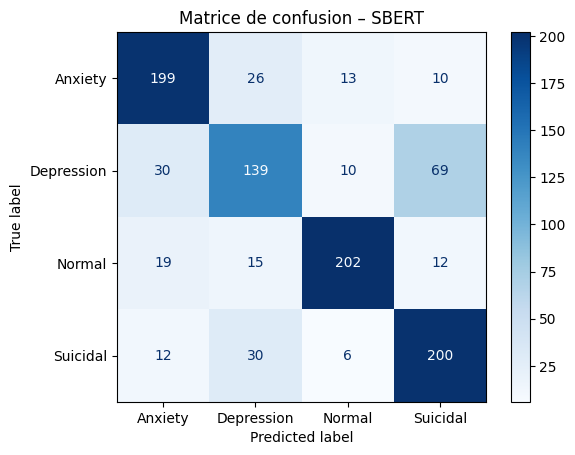

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Calcul de la matrice de confusion pour SBERT
cm_sbert = confusion_matrix(y_test, test_pred_sbert)

# Affichage graphique
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_sbert,
    display_labels=label_encoder.classes_
)

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Matrice de confusion – SBERT")
plt.grid(False)
plt.savefig("/kaggle/working/confusion_sbert_test.png", dpi=150)
plt.show()


In [16]:
## from sklearn.metrics import accuracy_score, f1_score

# Stockage centralisé des résultats de tous les runs
RESULTS = []

# Fonction utilitaire de calcul des métriques
def compute_metrics(y_true, y_pred):
    return {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1_macro": float(f1_score(y_true, y_pred, average="macro")),
        "f1_weighted": float(f1_score(y_true, y_pred, average="weighted")),
    }

RESULTS = []

# Fonction utilitaire de stockage des métriques
def add_result(modele, embeddings, split, y_true, y_pred):
    row = {
        "modele": modele,
        "embeddings": embeddings,
        "split": split,
        **compute_metrics(y_true, y_pred),
    }
    RESULTS.append(row)
    return row


In [17]:
from sklearn.metrics import accuracy_score, f1_score

# --- Enregistrer les métriques LR dans des variables dédiées ---
# Stocker les métriques LR (SBERT) pour réutilisation
row_lr_sbert_val = add_result("LogisticRegression", "SBERT", "validation", y_val, val_pred_sbert)
row_lr_sbert_test = add_result("LogisticRegression", "SBERT", "test", y_test, test_pred_sbert)

In [18]:
# Sauvegarder LR+SBERT est le meilleur à ce stade ... (accuracy test)
save_if_best(
    model_obj=clf_sbert,
    model_type="sklearn",
    model_filename="clf_lr_sbert.joblib",
    embedding_model_name=sbert_name,
    accuracy=test_rep_sbert["accuracy"]
)

Pas meilleur: 0.7460 <= 0.8317


In [19]:
# Libérer la mémoire GPU entre SBERT et BGE
import gc, torch

del sbert, X_tr_sbert, X_val_sbert, X_test_sbert
gc.collect()
torch.cuda.empty_cache()

## Nouveau modèle : BGE‑M3 embeddings + régression logistique

In [20]:
# Modèle BGE-M3 (embeddings récents)
bge_name = "BAAI/bge-m3"
bge = SentenceTransformer(bge_name)
bge.max_seq_length = 128


# Option utile pour accélérer (réduit la longueur max traitée)
# bge.max_seq_length = 256

X_tr_bge = embed_with_cache(bge, X_tr, "/kaggle/working/X_tr_bge.npy", batch_size=8)
X_val_bge = embed_with_cache(bge, X_val, "/kaggle/working/X_val_bge.npy", batch_size=8)
X_test_bge = embed_with_cache(bge, X_test, "/kaggle/working/X_test_bge.npy", batch_size=8)


clf_bge, val_pred_bge, test_pred_bge, val_rep_bge, test_rep_bge = train_and_eval(
    X_tr_bge, X_val_bge, X_test_bge, y_tr, y_val, y_test, label_encoder.classes_
)

print("BGE-M3 - validation")
print(classification_report(y_val, val_pred_bge, target_names=label_encoder.classes_))
print("BGE-M3 - test")
print(classification_report(y_test, test_pred_bge, target_names=label_encoder.classes_))

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

BGE-M3 - validation
              precision    recall  f1-score   support

     Anxiety       0.70      0.86      0.77      1101
  Depression       0.76      0.65      0.70      2901
      Normal       0.92      0.91      0.92      3678
    Suicidal       0.68      0.75      0.71      2243

    accuracy                           0.79      9923
   macro avg       0.77      0.79      0.78      9923
weighted avg       0.80      0.79      0.79      9923

BGE-M3 - test
              precision    recall  f1-score   support

     Anxiety       0.78      0.83      0.80       248
  Depression       0.67      0.70      0.68       248
      Normal       0.87      0.80      0.84       248
    Suicidal       0.80      0.77      0.78       248

    accuracy                           0.78       992
   macro avg       0.78      0.78      0.78       992
weighted avg       0.78      0.78      0.78       992



In [21]:
# Stocker les métriques LR (BGE-M3) pour réutilisation
row_lr_bge_val = add_result("LogisticRegression", "BGE-M3", "validation", y_val, val_pred_bge)
row_lr_bge_test = add_result("LogisticRegression", "BGE-M3", "test", y_test, test_pred_bge)

In [22]:
# Comparer et sauvegarder si LR+BGE-M3 est meilleur (accuracy test)
save_if_best(
    model_obj=clf_bge,
    model_type="sklearn",
    model_filename="clf_lr_bge.joblib",
    embedding_model_name=bge_name,
    accuracy=test_rep_bge["accuracy"]
)

Pas meilleur: 0.7752 <= 0.8317


In [23]:
# Matrice de confusion BGE-M3 sur le test
confusion_matrix(y_test, test_pred_bge)

array([[207,  31,   6,   4],
       [ 34, 173,  12,  29],
       [ 18,  16, 199,  15],
       [  8,  39,  11, 190]])

<Figure size 600x600 with 0 Axes>

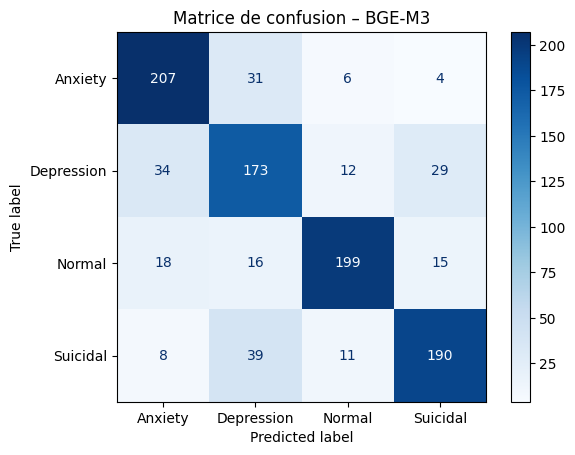

In [24]:
# Calcul de la matrice de confusion pour BGE-M3
cm_bge = confusion_matrix(y_test, test_pred_bge)

# Affichage graphique
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_bge,
    display_labels=label_encoder.classes_
)

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Matrice de confusion – BGE-M3")
plt.grid(False)
plt.savefig("/kaggle/working/confusion_bge-m3_test.png", dpi=150)
plt.show()


## Comparaison synthétique

In [25]:
# Tableau de comparaison (macro F1 et accuracy)
def extract_metrics(rep):
    return {
        "accuracy": rep["accuracy"],
        "f1_macro": rep["macro avg"]["f1-score"],
        "precision_macro": rep["macro avg"]["precision"],
        "recall_macro": rep["macro avg"]["recall"],
    }

rows = []
rows.append({"modele": "SBERT", "split": "validation", **extract_metrics(val_rep_sbert)})
rows.append({"modele": "SBERT", "split": "test", **extract_metrics(test_rep_sbert)})
rows.append({"modele": "BGE-M3", "split": "validation", **extract_metrics(val_rep_bge)})
rows.append({"modele": "BGE-M3", "split": "test", **extract_metrics(test_rep_bge)})

df_compare = pd.DataFrame(rows)
df_compare

,modele,split,accuracy,f1_macro,precision_macro,recall_macro
0,SBERT,validation,0.793308,0.776747,0.767940,0.791492
1,SBERT,test,0.745968,0.743998,0.747258,0.745968
2,BGE-M3,validation,0.791293,0.775097,0.765716,0.791226
3,BGE-M3,test,0.775202,0.776089,0.778590,0.775202


In [26]:
# Sauvegarde des métriques
out_path = "/kaggle/working/metrics_compare.csv"
df_compare.to_csv(out_path, index=False)
out_path

'/kaggle/working/metrics_compare.csv'

## Notes

- Le jeu `mental_health_combined_test.csv` est réservé à l’évaluation finale.
- Le fichier `mental_heath_feature_engineered.csv` est utile pour des baselines classiques, mais pas nécessaire pour SBERT/BGE.
lightgbm- Autres options si la RAM GPU est limitée, `batch_size` ou fixe `max_seq_length = 256`.

In [27]:
!pip -q install -U lightgbm


In [28]:
import os
import json
import numpy as np
import pandas as pd

import lightgbm as lgb

from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, f1_score


In [29]:
def run_lgbm_multiclass(X_tr_emb, y_tr, X_val_emb, y_val, X_test_emb, y_test, class_names, run_name, seed=42):
    # LightGBM aime bien le float32
    X_tr_emb = X_tr_emb.astype(np.float32)
    X_val_emb = X_val_emb.astype(np.float32)
    X_test_emb = X_test_emb.astype(np.float32)

    train_set = lgb.Dataset(X_tr_emb, label=y_tr)
    val_set = lgb.Dataset(X_val_emb, label=y_val, reference=train_set)

    params = {
        "objective": "multiclass",
        "num_class": len(class_names),
        "metric": "multi_logloss",
        "learning_rate": 0.05,
        "num_leaves": 63,
        "feature_fraction": 0.9,
        "bagging_fraction": 0.9,
        "bagging_freq": 1,
        "min_data_in_leaf": 30,
        "lambda_l2": 1.0,
        "verbosity": -1,
        "seed": seed,
    }

    model = lgb.train(
        params,
        train_set,
        num_boost_round=5000,
        valid_sets=[val_set],
        valid_names=["val"],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=50),
        ],
    )

    val_proba = model.predict(X_val_emb)
    test_proba = model.predict(X_test_emb)

    val_pred = np.argmax(val_proba, axis=1)
    test_pred = np.argmax(test_proba, axis=1)

    print(f"{run_name} - validation")
    print(classification_report(y_val, val_pred, target_names=class_names))

    print(f"{run_name} - test")
    print(classification_report(y_test, test_pred, target_names=class_names))

    # Ajout des résultats dans notre tableau de comparaison
    add_result("LightGBM", run_name, "test", y_test, test_pred)

    return model, val_pred, test_pred, val_proba, test_proba


In [30]:
# Chargement des embeddings 

# SBERT
X_tr_sbert  = np.load("/kaggle/working/X_tr_sbert.npy")
X_val_sbert = np.load("/kaggle/working/X_val_sbert.npy")
X_test_sbert = np.load("/kaggle/working/X_test_sbert.npy")

# BGE-M3
X_tr_bge  = np.load("/kaggle/working/X_tr_bge.npy")
X_val_bge = np.load("/kaggle/working/X_val_bge.npy")
X_test_bge = np.load("/kaggle/working/X_test_bge.npy")

print("SBERT :", X_tr_sbert.shape, X_val_sbert.shape, X_test_sbert.shape)
print("BGE-M3:", X_tr_bge.shape, X_val_bge.shape, X_test_bge.shape)

SBERT : (39689, 768) (9923, 768) (992, 768)
BGE-M3: (39689, 1024) (9923, 1024) (992, 1024)


In [31]:

model_lgb, val_pred_lgb, test_pred_lgb, val_proba_lgb, test_proba_lgb = run_lgbm_multiclass(
    X_tr_sbert, y_tr,
    X_val_sbert, y_val,
    X_test_sbert, y_test,
    label_encoder.classes_,
    run_name="SBERT"
)


Training until validation scores don't improve for 100 rounds
[50]	val's multi_logloss: 0.607796
[100]	val's multi_logloss: 0.536296
[150]	val's multi_logloss: 0.514074
[200]	val's multi_logloss: 0.504432
[250]	val's multi_logloss: 0.500937
[300]	val's multi_logloss: 0.501858
[350]	val's multi_logloss: 0.505255
Early stopping, best iteration is:
[251]	val's multi_logloss: 0.500809
SBERT - validation
              precision    recall  f1-score   support

     Anxiety       0.86      0.74      0.80      1101
  Depression       0.71      0.72      0.71      2901
      Normal       0.89      0.95      0.92      3678
    Suicidal       0.71      0.68      0.69      2243

    accuracy                           0.80      9923
   macro avg       0.79      0.77      0.78      9923
weighted avg       0.80      0.80      0.80      9923

SBERT - test
              precision    recall  f1-score   support

     Anxiety       0.93      0.68      0.79       248
  Depression       0.70      0.65      0

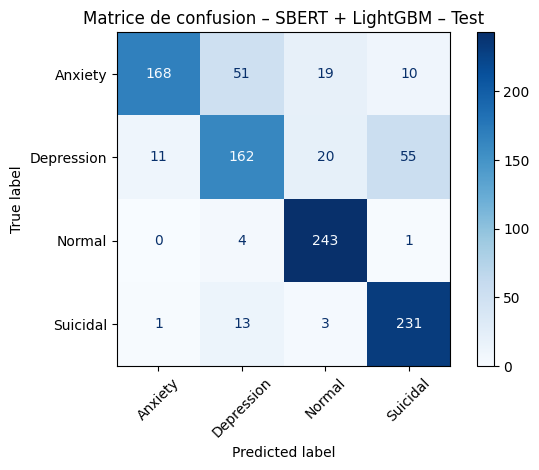

In [32]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    test_pred_lgb,
    display_labels=label_encoder.classes_,
    cmap="Blues",
    xticks_rotation=45
)

plt.title("Matrice de confusion – SBERT + LightGBM – Test")
plt.tight_layout()
plt.savefig("/kaggle/working/confusion_sbert_LGBM_test.png", dpi=150)
plt.show()

In [33]:
# Utiliser les métriques déjà calculées via add_result pour LightGBM+SBERT
row_lgb_sbert = add_result("LightGBM", "SBERT", "test", y_test, test_pred_lgb)
save_if_best(
    model_obj=model_lgb,
    model_type="lightgbm",
    model_filename="clf_lgb_sbert.txt",
    embedding_model_name=sbert_name,
    accuracy=row_lgb_sbert["accuracy"]
)

Pas meilleur: 0.8105 <= 0.8317


In [34]:

model_lgb_bge, val_pred_lgb_bge, test_pred_lgb_bge, val_proba_lgb_bge, test_proba_lgb_bge = run_lgbm_multiclass(
    X_tr_bge, y_tr,
    X_val_bge, y_val,
    X_test_bge, y_test,
    label_encoder.classes_,
    run_name="BGE-M3"
)


Training until validation scores don't improve for 100 rounds
[50]	val's multi_logloss: 0.642957
[100]	val's multi_logloss: 0.562562
[150]	val's multi_logloss: 0.53448
[200]	val's multi_logloss: 0.521386
[250]	val's multi_logloss: 0.515094
[300]	val's multi_logloss: 0.512236
[350]	val's multi_logloss: 0.512977
[400]	val's multi_logloss: 0.515158
Early stopping, best iteration is:
[306]	val's multi_logloss: 0.511955
BGE-M3 - validation
              precision    recall  f1-score   support

     Anxiety       0.84      0.70      0.77      1101
  Depression       0.70      0.73      0.72      2901
      Normal       0.90      0.94      0.92      3678
    Suicidal       0.71      0.67      0.69      2243

    accuracy                           0.79      9923
   macro avg       0.79      0.76      0.77      9923
weighted avg       0.79      0.79      0.79      9923

BGE-M3 - test
              precision    recall  f1-score   support

     Anxiety       0.97      0.62      0.76       248
  D

In [35]:
import numpy as np

# Sauvegarde des prédictions et probabilités (test)
np.save("/kaggle/working/test_pred_lgb_bge.npy", test_pred_lgb_bge)
np.save("/kaggle/working/test_proba_lgb_bge.npy", test_proba_lgb_bge)

# Sauvegarde optionnelle côté validation (pour optimiser des seuils)
np.save("/kaggle/working/val_pred_lgb_bge.npy", val_pred_lgb_bge)
np.save("/kaggle/working/val_proba_lgb_bge.npy", val_proba_lgb_bge)

# dimension des embeddings
print("Dimension embeddings BGE-M3:", X_tr_bge.shape[1])


Dimension embeddings BGE-M3: 1024


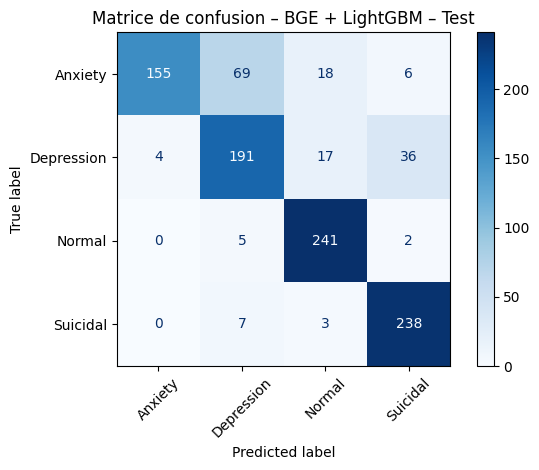

In [36]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    test_pred_lgb_bge,
    display_labels=label_encoder.classes_,
    cmap="Blues",
    xticks_rotation=45
)

plt.title("Matrice de confusion – BGE + LightGBM – Test")
plt.tight_layout()
plt.savefig("/kaggle/working/confusion_BGE_LGBM_test.png", dpi=150)
plt.show()

In [37]:
# Utiliser les métriques déjà calculées via add_result pour LightGBM+BGE-M3
row_lgb_bge = add_result("LightGBM", "BGE-M3", "test", y_test, test_pred_lgb_bge)
save_if_best(
    model_obj=model_lgb_bge,
    model_type="lightgbm",
    model_filename="clf_lgb_bge.txt",
    embedding_model_name=bge_name,
    accuracy=row_lgb_bge["accuracy"]
)

Pas meilleur: 0.8317 <= 0.8317


In [38]:
def run_linear_svm(X_tr_emb, y_tr, X_val_emb, y_val, X_test_emb, y_test, class_names, run_name):
    # LinearSVC marche bien en haute dimension (embeddings), très bon baseline
    clf = LinearSVC(class_weight="balanced", random_state=42)
    clf.fit(X_tr_emb, y_tr)

    val_pred = clf.predict(X_val_emb)
    test_pred = clf.predict(X_test_emb)

    print(f"{run_name} - validation")
    print(classification_report(y_val, val_pred, target_names=class_names))

    print(f"{run_name} - test")
    print(classification_report(y_test, test_pred, target_names=class_names))

    add_result("LinearSVM", run_name, "test", y_test, test_pred)

    return clf, val_pred, test_pred


In [39]:
clf_svm_sbert, val_pred_svm_sbert, test_pred_svm_sbert = run_linear_svm(
    X_tr_sbert, y_tr,
    X_val_sbert, y_val,
    X_test_sbert, y_test,
    label_encoder.classes_,
    run_name="SBERT"
)


SBERT - validation
              precision    recall  f1-score   support

     Anxiety       0.75      0.83      0.79      1101
  Depression       0.75      0.68      0.71      2901
      Normal       0.91      0.93      0.92      3678
    Suicidal       0.70      0.72      0.71      2243

    accuracy                           0.80      9923
   macro avg       0.78      0.79      0.78      9923
weighted avg       0.80      0.80      0.80      9923

SBERT - test
              precision    recall  f1-score   support

     Anxiety       0.83      0.79      0.81       248
  Depression       0.68      0.60      0.64       248
      Normal       0.85      0.85      0.85       248
    Suicidal       0.69      0.80      0.74       248

    accuracy                           0.76       992
   macro avg       0.76      0.76      0.76       992
weighted avg       0.76      0.76      0.76       992



In [40]:
# Utiliser les métriques déjà calculées via add_result pour SVM+SBERT
row_svm_sbert = add_result("LinearSVM", "SBERT", "test", y_test, test_pred_svm_sbert)
save_if_best(
    model_obj=clf_svm_sbert,
    model_type="sklearn",
    model_filename="clf_svm_sbert.joblib",
    embedding_model_name=sbert_name,
    accuracy=row_svm_sbert["accuracy"]
)


Pas meilleur: 0.7611 <= 0.8317


In [41]:
clf_svm_bge, val_pred_svm_bge, test_pred_svm_bge = run_linear_svm(
    X_tr_bge, y_tr,
    X_val_bge, y_val,
    X_test_bge, y_test,
    label_encoder.classes_,
    run_name="BGE-M3"
)


BGE-M3 - validation
              precision    recall  f1-score   support

     Anxiety       0.75      0.84      0.79      1101
  Depression       0.76      0.67      0.71      2901
      Normal       0.91      0.93      0.92      3678
    Suicidal       0.69      0.74      0.72      2243

    accuracy                           0.80      9923
   macro avg       0.78      0.79      0.78      9923
weighted avg       0.80      0.80      0.80      9923

BGE-M3 - test
              precision    recall  f1-score   support

     Anxiety       0.79      0.83      0.81       248
  Depression       0.69      0.72      0.70       248
      Normal       0.87      0.84      0.85       248
    Suicidal       0.84      0.78      0.81       248

    accuracy                           0.79       992
   macro avg       0.80      0.79      0.79       992
weighted avg       0.80      0.79      0.79       992



In [42]:
# Utiliser les métriques déjà calculées via add_result pour SVM+BGE-M3
row_svm_bge = add_result("LinearSVM", "BGE-M3", "test", y_test, test_pred_svm_bge)
save_if_best(
    model_obj=clf_svm_bge,
    model_type="sklearn",
    model_filename="clf_svm_bge.joblib",
    embedding_model_name=bge_name,
    accuracy=row_svm_bge["accuracy"]
)


Pas meilleur: 0.7923 <= 0.8317


In [43]:
df_results = pd.DataFrame(RESULTS).sort_values(["accuracy"])
df_results


,modele,embeddings,split,accuracy,f1_macro,f1_weighted
1,LogisticRegression,SBERT,test,0.745968,0.743998,0.743998
8,LinearSVM,SBERT,test,0.761089,0.760193,0.760193
9,LinearSVM,SBERT,test,0.761089,0.760193,0.760193
3,LogisticRegression,BGE-M3,test,0.775202,0.776089,0.776089
2,LogisticRegression,BGE-M3,validation,0.791293,0.775097,0.790899
10,LinearSVM,BGE-M3,test,0.792339,0.793167,0.793167
11,LinearSVM,BGE-M3,test,0.792339,0.793167,0.793167
0,LogisticRegression,SBERT,validation,0.793308,0.776747,0.792355
5,LightGBM,SBERT,test,0.810484,0.805599,0.805599
4,LightGBM,SBERT,test,0.810484,0.805599,0.805599


In [44]:
out_csv = "/kaggle/working/results_embeddings_classifiers.csv"
df_results.to_csv(out_csv, index=False)
out_csv


'/kaggle/working/results_embeddings_classifiers.csv'

In [45]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report


In [46]:
def run_mlp(X_tr_emb, y_tr, X_val_emb, y_val, X_test_emb, y_test, class_names, run_name):
    # MLP non linéaire avec early stopping sur un split interne du train
    # On garde ton vrai X_val pour l'évaluation comparable aux autres modèles
    clf = MLPClassifier(
        hidden_layer_sizes=(256, 128),
        activation="relu",
        solver="adam",
        alpha=1e-4,
        batch_size=256,
        learning_rate_init=1e-3,
        max_iter=200,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        random_state=42
    )

    clf.fit(X_tr_emb, y_tr)

    val_pred = clf.predict(X_val_emb)
    test_pred = clf.predict(X_test_emb)

    print(f"{run_name} - validation")
    print(classification_report(y_val, val_pred, target_names=class_names))

    print(f"{run_name} - test")
    print(classification_report(y_test, test_pred, target_names=class_names))

    add_result("MLP", run_name, "test", y_test, test_pred)

    return clf, val_pred, test_pred


In [47]:
clf_mlp_sbert, val_pred_mlp_sbert, test_pred_mlp_sbert = run_mlp(
    X_tr_sbert, y_tr,
    X_val_sbert, y_val,
    X_test_sbert, y_test,
    label_encoder.classes_,
    run_name="SBERT"
)


SBERT - validation
              precision    recall  f1-score   support

     Anxiety       0.85      0.79      0.82      1101
  Depression       0.75      0.72      0.73      2901
      Normal       0.89      0.96      0.92      3678
    Suicidal       0.72      0.70      0.71      2243

    accuracy                           0.81      9923
   macro avg       0.80      0.79      0.80      9923
weighted avg       0.81      0.81      0.81      9923

SBERT - test
              precision    recall  f1-score   support

     Anxiety       0.90      0.73      0.80       248
  Depression       0.65      0.68      0.66       248
      Normal       0.83      0.90      0.86       248
    Suicidal       0.74      0.76      0.75       248

    accuracy                           0.77       992
   macro avg       0.78      0.77      0.77       992
weighted avg       0.78      0.77      0.77       992



In [48]:
# Utiliser les métriques déjà calculées via add_result pour MLP+SBERT
row_mlp_sbert = add_result("MLP", "SBERT", "test", y_test, test_pred_mlp_sbert)
save_if_best(
    model_obj=clf_mlp_sbert,
    model_type="sklearn",
    model_filename="clf_mlp_sbert.joblib",
    embedding_model_name=sbert_name,
    accuracy=row_mlp_sbert["accuracy"]
)

Pas meilleur: 0.7692 <= 0.8317


In [49]:
clf_mlp_bge, val_pred_mlp_bge, test_pred_mlp_bge = run_mlp(
    X_tr_bge, y_tr,
    X_val_bge, y_val,
    X_test_bge, y_test,
    label_encoder.classes_,
    run_name="BGE-M3"
)

BGE-M3 - validation
              precision    recall  f1-score   support

     Anxiety       0.81      0.81      0.81      1101
  Depression       0.70      0.76      0.73      2901
      Normal       0.94      0.92      0.93      3678
    Suicidal       0.73      0.66      0.69      2243

    accuracy                           0.80      9923
   macro avg       0.79      0.79      0.79      9923
weighted avg       0.81      0.80      0.80      9923

BGE-M3 - test
              precision    recall  f1-score   support

     Anxiety       0.87      0.79      0.83       248
  Depression       0.65      0.85      0.73       248
      Normal       0.93      0.88      0.90       248
    Suicidal       0.93      0.77      0.85       248

    accuracy                           0.82       992
   macro avg       0.84      0.82      0.83       992
weighted avg       0.84      0.82      0.83       992



In [50]:
# Utiliser les métriques déjà calculées via add_result pour MLP+BGE-M3
row_mlp_bge = add_result("MLP", "BGE-M3", "test", y_test, test_pred_mlp_bge)
save_if_best(
    model_obj=clf_mlp_bge,
    model_type="sklearn",
    model_filename="clf_mlp_bge.joblib",
    embedding_model_name=bge_name,
    accuracy=row_mlp_bge["accuracy"]
)

Pas meilleur: 0.8236 <= 0.8317


In [51]:
df_results = pd.DataFrame(RESULTS).sort_values(["accuracy"])
df_results


,modele,embeddings,split,accuracy,f1_macro,f1_weighted
1,LogisticRegression,SBERT,test,0.745968,0.743998,0.743998
8,LinearSVM,SBERT,test,0.761089,0.760193,0.760193
9,LinearSVM,SBERT,test,0.761089,0.760193,0.760193
13,MLP,SBERT,test,0.769153,0.769726,0.769726
12,MLP,SBERT,test,0.769153,0.769726,0.769726
3,LogisticRegression,BGE-M3,test,0.775202,0.776089,0.776089
2,LogisticRegression,BGE-M3,validation,0.791293,0.775097,0.790899
11,LinearSVM,BGE-M3,test,0.792339,0.793167,0.793167
10,LinearSVM,BGE-M3,test,0.792339,0.793167,0.793167
0,LogisticRegression,SBERT,validation,0.793308,0.776747,0.792355


In [52]:
out_csv = "/kaggle/working/results_embeddings_classifiers.csv"
df_results.to_csv(out_csv, index=False)
out_csv

'/kaggle/working/results_embeddings_classifiers.csv'

In [53]:
import pandas as pd

# Chemin du fichier exporté précédemment
results_path = "/kaggle/working/results_embeddings_classifiers.csv"

df_results = pd.read_csv(results_path)

print(df_results)
print(df_results.shape)


                modele embeddings       split  accuracy  f1_macro  f1_weighted
0   LogisticRegression      SBERT        test  0.745968  0.743998     0.743998
1            LinearSVM      SBERT        test  0.761089  0.760193     0.760193
2            LinearSVM      SBERT        test  0.761089  0.760193     0.760193
3                  MLP      SBERT        test  0.769153  0.769726     0.769726
4                  MLP      SBERT        test  0.769153  0.769726     0.769726
5   LogisticRegression     BGE-M3        test  0.775202  0.776089     0.776089
6   LogisticRegression     BGE-M3  validation  0.791293  0.775097     0.790899
7            LinearSVM     BGE-M3        test  0.792339  0.793167     0.793167
8            LinearSVM     BGE-M3        test  0.792339  0.793167     0.793167
9   LogisticRegression      SBERT  validation  0.793308  0.776747     0.792355
10            LightGBM      SBERT        test  0.810484  0.805599     0.805599
11            LightGBM      SBERT        test  0.810

In [54]:
import pandas as pd

# DataFrame brut
#df_results = pd.DataFrame(RESULTS)

# On garde uniquement le split test
df_test = df_results[df_results["split"] == "test"].copy()

# Suppression des doublons éventuels (sécurité)
df_test = df_test.drop_duplicates(subset=["embeddings", "modele", "split"])

# Tri par accuracy puis f1_weighted (du meilleur au moins bon)
df_test = df_test.sort_values(
    by=["accuracy", "f1_weighted"],
    ascending=False
).reset_index(drop=True)

df_test.head(10)


,modele,embeddings,split,accuracy,f1_macro,f1_weighted
0,LightGBM,BGE-M3,test,0.831653,0.827253,0.827253
1,MLP,BGE-M3,test,0.823589,0.828178,0.828178
2,LightGBM,SBERT,test,0.810484,0.805599,0.805599
3,LinearSVM,BGE-M3,test,0.792339,0.793167,0.793167
4,LogisticRegression,BGE-M3,test,0.775202,0.776089,0.776089
5,MLP,SBERT,test,0.769153,0.769726,0.769726
6,LinearSVM,SBERT,test,0.761089,0.760193,0.760193
7,LogisticRegression,SBERT,test,0.745968,0.743998,0.743998


In [55]:
import os
import json
import joblib
import numpy as np

# --- Sauvegarde des prédictions (utile pour analyses d’erreurs) ---
np.save("/kaggle/working/val_pred_sbert.npy", val_pred_sbert)
np.save("/kaggle/working/test_pred_sbert.npy", test_pred_sbert)
np.save("/kaggle/working/val_pred_bge.npy", val_pred_bge)
np.save("/kaggle/working/test_pred_bge.npy", test_pred_bge)

# --- Sauvegarde des résultats globaux (historique des modèles) ---
df_results.to_csv("/kaggle/working/results_embeddings_classifiers.csv", index=False)

# --- Vérifier que le best model a bien été enregistré ---
best_meta_path = "/kaggle/working/best_model_meta.json"
if os.path.exists(best_meta_path):
    with open(best_meta_path, "r", encoding="utf-8") as f:
        best_meta = json.load(f)
    print("Best model trouvé:", best_meta)
else:
    print("Aucun best model trouvé. Vérifie que save_if_best a été exécuté.")

# --- Sauvegarder l’encoder (nécessaire pour l’inférence) ---
joblib.dump(label_encoder, "/kaggle/working/label_encoder.joblib")

print("Sauvegarde terminée")


Best model trouvé: {'accuracy': 0.8316532258064516, 'model_type': 'lightgbm', 'model_filename': 'clf_lgb_bge.txt', 'embedding_model_name': 'BAAI/bge-m3'}
Sauvegarde terminée


In [56]:
import os
print(os.listdir("/kaggle/working"))


['confusion_BGE_LGBM_test.png', 'confusion_bge-m3_test.png', 'state.db', 'X_val_sbert.npy', 'X_test_bge.npy', 'X_tr_bge.npy', 'best_model_meta.json', 'results_embeddings_classifiers.csv', 'X_test_sbert.npy', 'metrics_compare.csv', 'val_pred_lgb_bge.npy', 'clf_lgb_sbert.txt', 'X_val_bge.npy', '.virtual_documents', 'val_pred_sbert.npy', 'test_pred_bge.npy', 'test_pred_lgb_bge.npy', 'test_proba_lgb_bge.npy', 'confusion_sbert_test.png', 'test_pred_sbert.npy', 'confusion_sbert_LGBM_test.png', 'X_tr_sbert.npy', 'val_pred_bge.npy', 'val_proba_lgb_bge.npy', 'clf_lgb_bge.txt', 'clf_lr_sbert.joblib', 'clf_lr_bge.joblib', 'label_encoder.joblib']


## Analyse qualitatives des résultâts pour BGE-M3+LightGBM

In [57]:
import numpy as np

test_pred_lgb_bge = np.load("/kaggle/working/test_pred_lgb_bge.npy")
test_proba_lgb_bge = np.load("/kaggle/working/test_proba_lgb_bge.npy")

val_pred_lgb_bge = np.load("/kaggle/working/val_pred_lgb_bge.npy")
val_proba_lgb_bge = np.load("/kaggle/working/val_proba_lgb_bge.npy")

### Extraire automatiquement TP / FN / FP sur “Suicidal” + tableau pour la

#### On extrait 9 exemples “propres” pour analyse qualitative :

3 TP Suicidal (bien détectés, proba Suicidal la plus haute)

3 FN Suicidal (loupés, mais proba Suicidal la plus haute → cas “limites”)

3 FP Suicidal (fausses alertes, proba Suicidal la plus haute)

In [58]:
import pandas as pd
import numpy as np

class_names = list(label_encoder.classes_)
idx_suicidal = class_names.index("Suicidal")

proba_suicidal = test_proba_lgb_bge[:, idx_suicidal]

is_true_suicidal = (y_test == idx_suicidal)
is_pred_suicidal = (test_pred_lgb_bge == idx_suicidal)

tp_idx = np.where(is_true_suicidal & is_pred_suicidal)[0]
fn_idx = np.where(is_true_suicidal & (~is_pred_suicidal))[0]
fp_idx = np.where((~is_true_suicidal) & is_pred_suicidal)[0]

tp_top = tp_idx[np.argsort(-proba_suicidal[tp_idx])][:3]
fn_top = fn_idx[np.argsort(-proba_suicidal[fn_idx])][:3]
fp_top = fp_idx[np.argsort(-proba_suicidal[fp_idx])][:3]

selected = np.concatenate([tp_top, fn_top, fp_top])

rows = []
for i in selected:
    rows.append({
        "index": int(i),
        "groupe": "TP_Suicidal" if i in tp_top else ("FN_Suicidal" if i in fn_top else "FP_Suicidal"),
        "vrai_label": class_names[int(y_test[i])],
        "label_predit": class_names[int(test_pred_lgb_bge[i])],
        "proba_suicidal": float(proba_suicidal[i]),
        "texte": X_test[i]
    })

df_cases = pd.DataFrame(rows).sort_values(["groupe", "proba_suicidal"], ascending=[True, False])
df_cases


,index,groupe,vrai_label,label_predit,proba_suicidal,texte
3,964,FN_Suicidal,Suicidal,Depression,0.323131,Never enough.Why am I never enough? It's like ...
4,987,FN_Suicidal,Suicidal,Normal,0.272557,Someone jumped off my building todayI wonder w...
5,795,FN_Suicidal,Suicidal,Depression,0.197177,"I hate talking about it so much, but I don't k..."
6,298,FP_Suicidal,Depression,Suicidal,0.938987,"everyday, multiple times a day, i think about ..."
7,440,FP_Suicidal,Depression,Suicidal,0.923821,i hate how fake this world is i don’t want any...
8,284,FP_Suicidal,Depression,Suicidal,0.920964,"word to the wise, if you want to commit suicid..."
0,825,TP_Suicidal,Suicidal,Suicidal,0.987345,"Ending it on my birthdayHi reddit, sorry if th..."
1,768,TP_Suicidal,Suicidal,Suicidal,0.985394,I want to kill myself but I don’t know how to ...
2,921,TP_Suicidal,Suicidal,Suicidal,0.981555,PleasePlease. I want to die. Please. Please. P...
